In [1]:
import numpy as np
a = np.array([[1,-2,3],[0,5,6]])

In [2]:
import pandas as pd
names = ['user_id', 'item_id', 'rating']
ratings_df = pd.read_csv('./ml-100k/test.data', sep=' ',encoding = "ISO-8859-1", names=names)

In [3]:
ratings_df.head()

,user_id,item_id,rating
0,1,3,2
1,1,1,5
2,2,2,3
3,2,4,5
4,2,3,1


In [4]:
n_users = len(ratings_df['user_id'].unique()) # find number of unique user
n_items = len(ratings_df['item_id'].unique())
R_shape = (n_users, n_items)
print(str(n_users) + ' users')
print(str(n_items) + ' items')

4 users
4 items


In [5]:
X = ratings_df[['user_id', 'item_id']].values # n * 2
y = ratings_df['rating'].values # 1 * n

In [6]:
from toolkit import ConvertToDense
R = ConvertToDense(X, y, R_shape)   

In [7]:
from sklearn.decomposition import NMF
import time
start_time = time.time()
nmf_model = NMF(n_components=100)  # (943*5 for W and 5*1682 for H) 
 
nmf_model.fit(R)                     
W = nmf_model.transform(R)         # user factor matrix
H = nmf_model.components_          # item latent factor matrix

elapse_time = time.time() - start_time
print(elapse_time)
print(W.shape)
print(H.shape)

0.018990278244018555
(4, 100)
(100, 4)


In [8]:
R_pred = np.matmul(W,H)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true=R, y_pred=R_pred)
print(mse)

7.671371810083647e-06


In [13]:
from sklearn.model_selection import KFold
def cross_val(model,X,y,error_func,nfolds=5):
    err = 0
    kfold = KFold(n_splits=nfolds)
    for train_index, test_index in kfold.split(X):   
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        R_train = ConvertToDense(X_train, y_train, R_shape)
        R_test = ConvertToDense(X_test, y_test, R_shape)

        # Here R_test contains more ratings

        model.fit(R_train)  
        W = model.transform(R_train)       
        H = model.components_    
        print("train")
        print(R_train)            

        # Making the predictions
        R_pred = np.matmul(W,H)    
    
        # Clipping values                                                    
        R_pred[R_pred > 5] = 5.           # clips ratings above 5             
        R_pred[R_pred < 1] = 1.           # clips ratings below 1

        # Computing the error 
        err += error_func(R_pred,R_test)

    return err

In [14]:
def rs_mse(R_pred,R_test):
    mask = (R_test>0) * 1
    # R_pred is close to R_train, but contains less info
    # than R_test,  
    print("pred")
    print(R_pred)
    print("test")
    print(R_test)
    print("add mask")
    print(R_pred*mask)
    
    mse = mean_squared_error(R_pred * mask, R_test)

    return mse

In [15]:
param_grid = {'n_components' : [5, 10, 15, 20, 25]}
import warnings
warnings.filterwarnings('ignore')
print("R")
print(R)
mses = []
min_mse = 10000000
for n_comp in param_grid['n_components']:
    nmf = NMF(n_components = n_comp)
    mse = cross_val(nmf,X,y,error_func=rs_mse)
    mses.append(mse)
    if mse<min_mse:
        min_mse = mse

R
[[5 0 2 0]
 [0 3 1 5]
 [2 4 0 5]
 [0 3 1 5]]
train
[[0 0 0 0]
 [0 0 1 5]
 [2 4 0 5]
 [0 3 1 5]]
pred
[[1. 1. 1. 1.]
 [1. 1. 1. 5.]
 [2. 4. 1. 5.]
 [1. 3. 1. 5.]]
test
[[5 0 2 0]
 [0 3 0 0]
 [0 0 0 0]
 [0 0 0 0]]
add mask
[[1. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
train
[[5 0 2 0]
 [0 3 0 0]
 [2 4 0 5]
 [0 3 1 5]]
pred
[[5.         1.         2.         1.        ]
 [1.         3.         1.         1.        ]
 [1.99999997 4.         1.         5.        ]
 [1.         3.00528216 1.         4.9980558 ]]
test
[[0 0 0 0]
 [0 0 1 5]
 [0 0 0 0]
 [0 0 0 0]]
add mask
[[0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
train
[[5 0 2 0]
 [0 3 1 5]
 [0 0 0 5]
 [0 3 1 5]]
pred
[[4.99880352 1.         2.00674488 1.        ]
 [1.         3.0000196  1.         5.        ]
 [1.         1.         1.         5.        ]
 [1.         3.0000196  1.         5.        ]]
test
[[0 0 0 0]
 [0 0 0 0]
 [2 4 0 0]
 [0 0 0 0]]
add mask
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [

Text(0, 0.5, 'MSE')

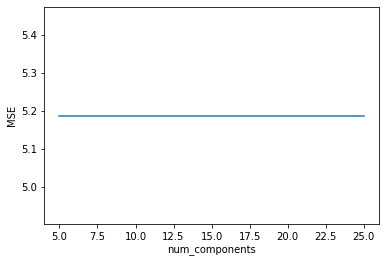

In [16]:
from matplotlib import pyplot as plt
plt.plot(param_grid['n_components'],mses)
plt.xlabel("num_components")
plt.ylabel("MSE")

In [17]:
nmf_model = NMF(n_components=20)     
nmf_model.fit(R)  
W = nmf_model.transform(R)       # user latent factors (= W, called the features matrix)
H = nmf_model.components_          # item latent factors (= H.T) (H is called the coefficient matrix)
R_pred = np.matmul(W,H)
print(R)
print(R_pred)

print(mean_squared_error(y_true=R, y_pred=R_pred))

[[5 0 2 0]
 [0 3 1 5]
 [2 4 0 5]
 [0 3 1 5]]
[[4.99985529e+00 3.75825353e-02 2.00291222e+00 3.21950656e-03]
 [2.45601334e-04 3.00000000e+00 1.00000010e+00 4.99999995e+00]
 [2.00000000e+00 4.00000000e+00 3.45327239e-15 5.00000000e+00]
 [2.45601334e-04 3.00000000e+00 1.00000010e+00 4.99999995e+00]]
8.94646745736385e-05
